In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, concatenate_datasets
import uptrain
import json
from helper_funcs import *

import warnings
warnings.simplefilter('ignore')

/Users/sourabhagrawal/miniconda3/envs/speech_to_text/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Summarization Tasks

In [2]:
billsum_dataset = load_dataset("billsum", split="ca_test")
billsum = billsum_dataset.train_test_split(test_size=0.2).filter(lambda x: x['text'] is not None)
billsum

Found cached dataset billsum (/Users/sourabhagrawal/.cache/huggingface/datasets/billsum/default/3.0.0/75cf1719d38d6553aa0e0714c393c74579b083ae6e164b2543684e3e92e0c4cc)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 317.53ba/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 989
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 248
    })
})

### Download the wikihow dataset
Download the wikihow dataset from https://ucsb.app.box.com/s/ap23l8gafpezf4tq3wapr6u8241zz358 and save it as 'wikihowAll.csv' in the current directory.

In [3]:
wikihow_dataset = load_dataset("csv", data_files='wikihowAll.csv').filter(lambda x: x['text'] is not None)
wikihow_dataset = wikihow_dataset.rename_column("headline", "summary")
wikihow_dataset

Using custom data configuration default-5b0f6db04b5599d3
Found cached dataset csv (/Users/sourabhagrawal/.cache/huggingface/datasets/csv/default-5b0f6db04b5599d3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.91it/s]
Loading cached processed dataset at /Users/sourabhagrawal/.cache/huggingface/datasets/csv/default-5b0f6db04b5599d3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-b11015b26ad529da.arrow


DatasetDict({
    train: Dataset({
        features: ['summary', 'title', 'text'],
        num_rows: 214294
    })
})

Create a small test dataset from the [Wikihow](https://github.com/mahnazkoupaee/WikiHow-Dataset) dataset to test our summarization model

In [4]:
wikihow = wikihow_dataset['train'].train_test_split(test_size=253)
wikihow

DatasetDict({
    train: Dataset({
        features: ['summary', 'title', 'text'],
        num_rows: 214041
    })
    test: Dataset({
        features: ['summary', 'title', 'text'],
        num_rows: 253
    })
})

#### Create a test dataset that contains both billsum and wikihow datasets for text summarization

In [5]:
final_test_dataset = concatenate_datasets([billsum["test"], wikihow["test"]])
label_bill = ['billsum_test' for _ in billsum["test"]]
label_wiki = ['wikihow_test' for _ in wikihow["test"]]
labels = label_bill + label_wiki
final_test_dataset = final_test_dataset.add_column("dataset_label", labels)
final_test_dataset = final_test_dataset.shuffle(seed=42)
final_test_dataset

Flattening the indices: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.74ba/s]


Dataset({
    features: ['text', 'summary', 'title', 'dataset_label'],
    num_rows: 501
})

#### Prefix the input with a prompt so that the T5 model knows this is a summarization task.

In [6]:
tokenizer_t5 = AutoTokenizer.from_pretrained("t5-small")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
prefix = "summarize: "
test_data_list = [prefix + doc for doc in final_test_dataset["text"] if doc is not None]

### Mark labels on the basis of the source dataset

In [7]:
config = {
    "checks": [{
        'type': uptrain.Visual.UMAP,
        "measurable_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'bert_embs'
        },
        "label_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'dataset_label'
        },
        'min_dist': 0.01,
        'n_neighbors': 20,
        'metric_umap': 'euclidean',
        'dim': '2D', # Use '2D' or '3D'
        "umap_update_freq": 5,
        'initial_dataset': "ref_dataset.json",
        "do_clustering": False
    },
    {
        'type': uptrain.Anomaly.DATA_DRIFT,
        "measurable_args": {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'bert_embs_downsampled'
        },
        "is_embedding": True,
        'reference_dataset': "ref_dataset.json",
    }],
    "st_logging": True,
}

In [8]:
framework = uptrain.Framework(cfg_dict=config)

batch_size = 10

for idx in range(int(len(final_test_dataset)/batch_size)):
    if idx % 10 == 0:
        print(idx)
    this_batch = [prefix + doc for doc in final_test_dataset[idx*batch_size: (idx+1)*batch_size]['text'] if doc is not None]

    # Text encoder
    input_embs = tokenizer_t5(this_batch, truncation=True, padding=True, return_tensors="pt").input_ids
    
    # Getting output values
    output_embs = model_t5.generate(input_embs)
    
    # Text decoder
    summaries = tokenizer_t5.batch_decode(output_embs, skip_special_tokens=True)

    bert_embs = convert_sentence_to_emb(summaries)
    # import pdb; pdb.set_trace()

    inputs = {
        "data": {
            "text": this_batch,
            "bert_embs": bert_embs,
            "bert_embs_downsampled": downsample_embs(bert_embs),
            "dataset_label": final_test_dataset[idx*batch_size: (idx+1)*batch_size]['dataset_label']
        }
    }

    idens = framework.log(inputs=inputs, outputs=summaries)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs
0

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.6.92:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


10
20
30
40
  Stopping...


Comparing the two summaries above (one by the model and one ground truth), we can notice that the model output is not very good. The model sees new data type (i.e., from the Wikihow dataset), and hence, not able to perform well (as also suggested by the data drift/separate clusters).

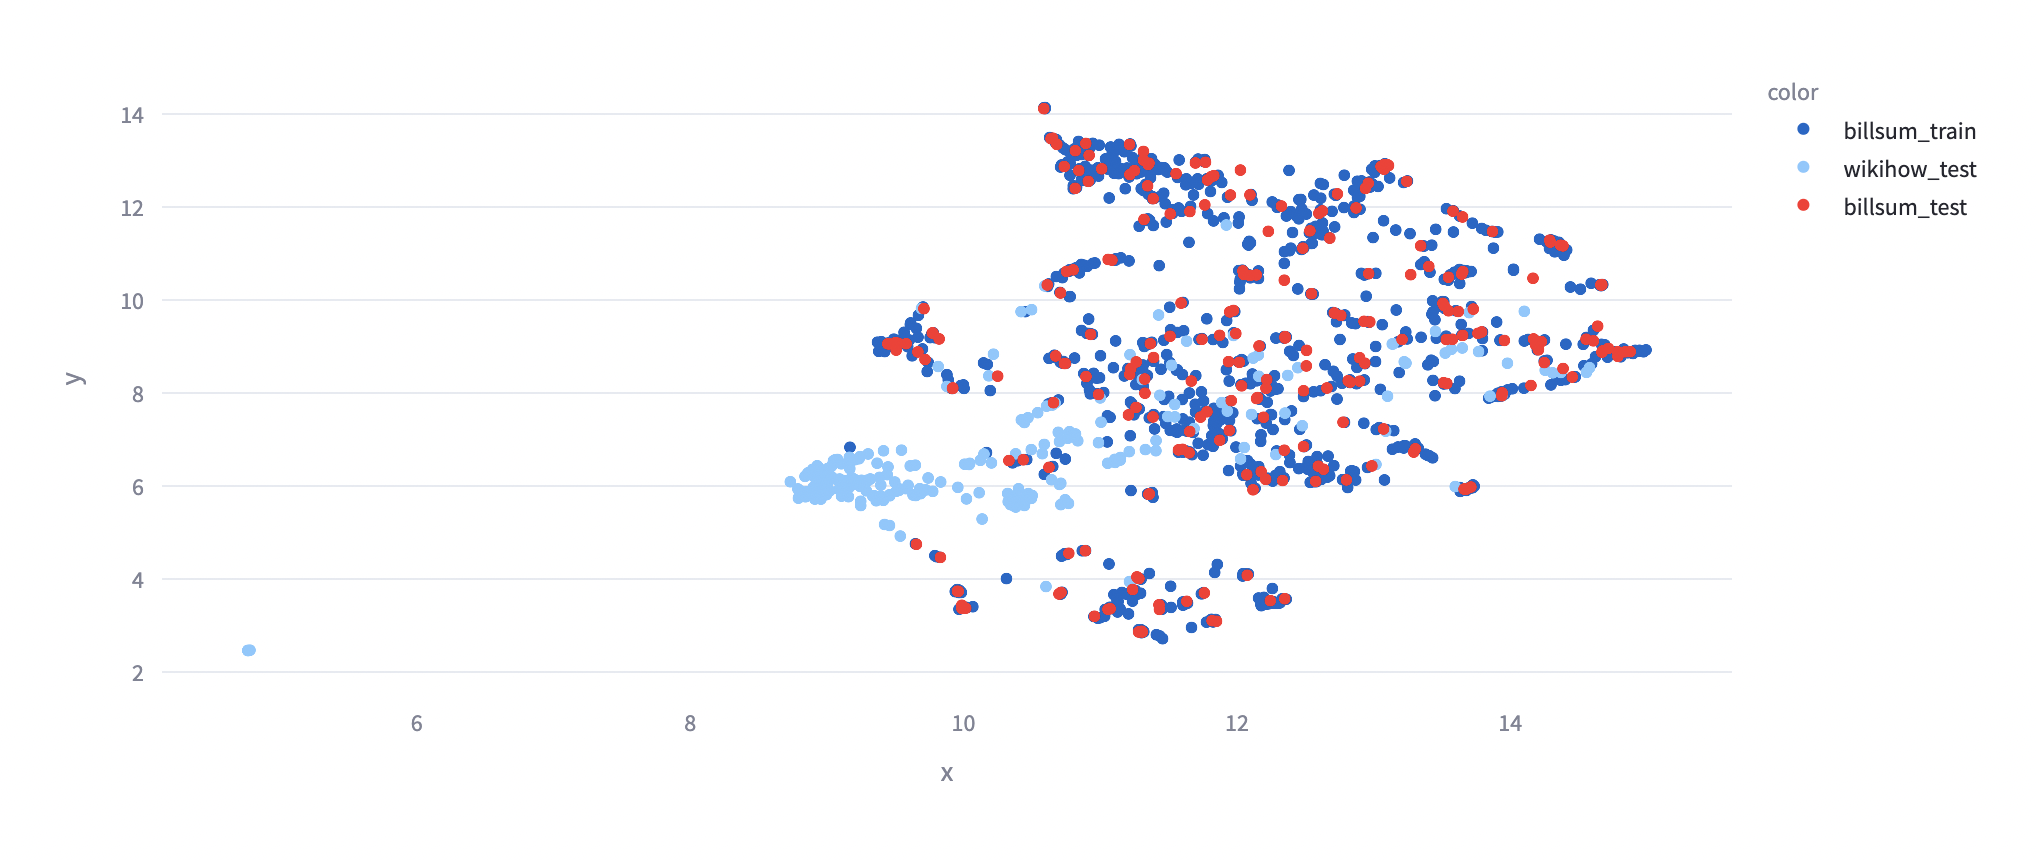